## Research on the Generalization Method for Predicting Building Envelope Heat Flow

# Based on KAN

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
from sympy import symbols, sympify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from kan import *  # 导入KAN 模块
from matplotlib.ticker import MaxNLocator

# Define early stopping training function with performance evaluation
def train_kan_with_early_stopping(model, dataset, patience=10, steps=10000):
    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for step in range(steps):
        optimizer.zero_grad()
        outputs = model(dataset['train_input'])
        loss = nn.MSELoss()(outputs, dataset['train_label'])
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = nn.MSELoss()(val_outputs, dataset['test_label']).item()
        
        if step % 10 == 0:  # Logging every 10 steps
            print(f'Step [{step+1}/{steps}], Val Loss: {val_loss:.4f}') 

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        # Check if early stopping is triggered by loss threshold
        if val_loss < 0.001:
            print("Stopping training as val loss is below 0.001")
            break

        if patience_counter >= patience:
            print("Early stopping triggered due to no improvement")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Calculate metrics after training
    with torch.no_grad():
        test_predictions = model(dataset['test_input']).flatten()
        mae, mse, r2 = calculate_metrics(test_predictions, dataset['test_label'], y_std, y_mean)
        print(f'MAE: {mae}, MSE: {mse}, R2: {r2}') 

# Define function to calculate performance metrics
def calculate_metrics(predictions, actuals, y_std, y_mean):
    predictions_denorm = predictions * y_std + y_mean
    actuals_denorm = actuals * y_std + y_mean
    mae = mean_absolute_error(actuals_denorm, predictions_denorm)
    mse = mean_squared_error(actuals_denorm, predictions_denorm)
    r2 = r2_score(actuals_denorm, predictions_denorm)
    return mae, mse, r2

def generate_hourly_series(start_month, start_day, end_month, end_day):
    y0 = 2001  # 非闰年
    y1 = y0 if start_month <= end_month else y0 + 1
    
    full_year = pd.date_range(start=f'{y0}-01-01', end=f'{y1}-12-31 23:00:00', freq='h')

    start_date = f'{y0}-{start_month:02d}-{start_day:02d}'
    end_date = f'{y1}-{end_month:02d}-{end_day:02d} 23:59:59'
    filtered_series = full_year[(full_year >= start_date) & (full_year <= end_date)]
    
    hours_in_year = (filtered_series - pd.Timestamp(f'{y0}-01-01')).total_seconds() // 3600
    hours_in_year = hours_in_year % 8760  # Normalize for non-leap year

    return hours_in_year


In [2]:
## 数据导入
dataset = pd.read_excel('K1-自保温-杭州.xlsx')
hours = generate_hourly_series(1, 1, 12, 31 )

data = dataset.iloc[hours].copy() 
data.reset_index(drop=True, inplace=True)

N = 24  # 时滞系数
M = 1; # 预测步长

for lag in range(1, N): # 生成时滞数据
    data[f'Outdoor_temp_lag_{lag}'] = data['Outdoor_temp'].shift(lag)


for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)
    
data.dropna(inplace=True) # 删除因为时滞而产生的NaN行

input_features = ['Outdoor_temp', 'Indoor_temp'] + [f'Outdoor_temp_lag_{i}' for i in range(1, N)] 
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)] # 选择输入和输出列

x_data = data[input_features].values  # 输入数据
y_data = data[output_features].values  # 输出数据

# 标准化数据
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std
y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# 转化为tensor 结构
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)

## 训练数据准备
train_size = int(0.8* len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

## 初始化KAN参数
model = KAN(width=[x_data.shape[1], y_data.shape[1]], grid=20, k=5, seed=0)

## KAN训练——第一次训练
train_kan_with_early_stopping(model, dataset, steps=200, patience=10)

lib = ['x'] # lib = ['x', 'sin', 'exp'] # 设计激活函数
model.auto_symbolic(lib=lib)

# KAN训练——减枝后第二次训练
train_kan_with_early_stopping(model, dataset, steps=2000, patience=10)

# 获得训练公式
symbolic_formula_normalized = model.symbolic_formula()[0][0]
print("Discovered Symbolic Formula (Normalized):")
print(symbolic_formula_normalized)

x_sym = symbols('x')
y_sym = symbols('y')
normalized_formula = sympify(symbolic_formula_normalized)

## 输出预测结果
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

Step [1/200], Val Loss: 0.3656
Step [11/200], Val Loss: 0.2774
Step [21/200], Val Loss: 0.2365
Step [31/200], Val Loss: 0.2124
Step [41/200], Val Loss: 0.1991
Step [51/200], Val Loss: 0.1893
Step [61/200], Val Loss: 0.1799
Step [71/200], Val Loss: 0.1716
Step [81/200], Val Loss: 0.1644
Step [91/200], Val Loss: 0.1579
Step [101/200], Val Loss: 0.1520
Step [111/200], Val Loss: 0.1467
Step [121/200], Val Loss: 0.1419
Step [131/200], Val Loss: 0.1374
Step [141/200], Val Loss: 0.1333
Step [151/200], Val Loss: 0.1296
Step [161/200], Val Loss: 0.1263
Step [171/200], Val Loss: 0.1232
Step [181/200], Val Loss: 0.1203
Step [191/200], Val Loss: 0.1176
MAE: 2.4123239517211914, MSE: 9.679060935974121, R2: 0.7047102475675682
fixing (0,0,0) with x, r2=0.5454751253128052
fixing (0,1,0) with x, r2=0.9659770131111145
fixing (0,2,0) with x, r2=0.3829922378063202
fixing (0,3,0) with x, r2=0.04574832320213318
fixing (0,4,0) with x, r2=0.7836876511573792
fixing (0,5,0) with x, r2=0.7947566509246826
fixing (

MAE: 0.7983607649803162, MSE: 1.0589100122451782, R2: 0.9873763918876648


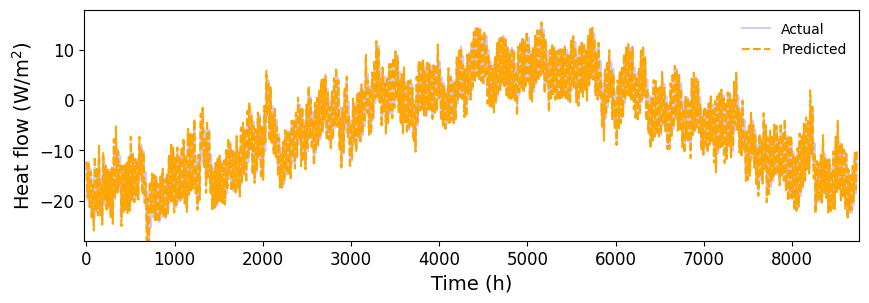

MAE: 0.7983607649803162, MSE: 1.0589100122451782, R2: 0.9873763918876648


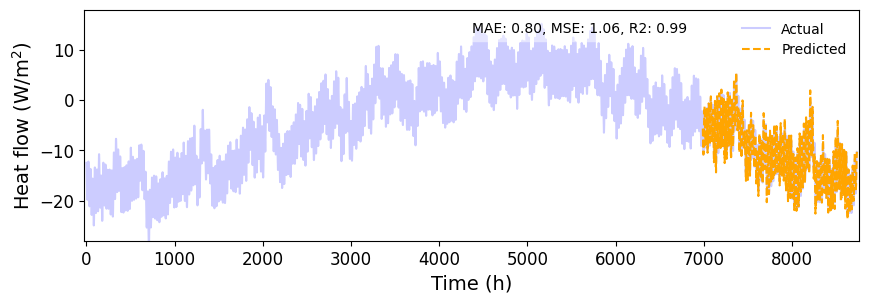

MAE: 1.37973952293396, MSE: 2.858391761779785, R2: 0.9135763049125671


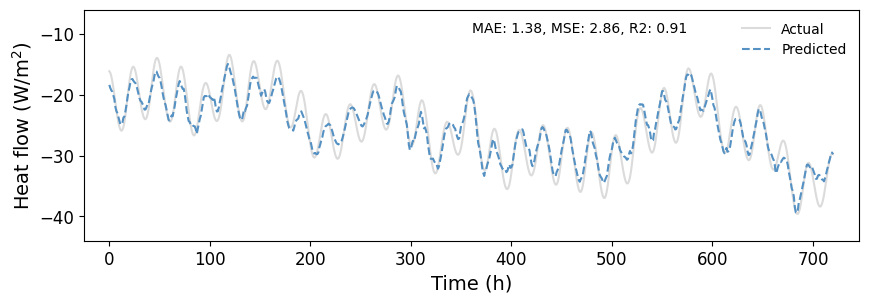

In [3]:
## 数据导入
dataset = pd.read_excel('K1-自保温-杭州.xlsx')
hours = generate_hourly_series(1, 1, 12, 31 )

data = dataset.iloc[hours].copy() 
data.reset_index(drop=True, inplace=True)

N = 24  # 时滞系数
M = 1; # 预测步长

for lag in range(1, N): # 生成时滞数据
    data[f'Outdoor_temp_lag_{lag}'] = data['Outdoor_temp'].shift(lag)

for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)
    
data.dropna(inplace=True) # 删除因为时滞而产生的NaN行

input_features = ['Outdoor_temp', 'Indoor_temp'] + [f'Outdoor_temp_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)] # 选择输入和输出列

x_data = data[input_features].values  # 输入数据
y_data = data[output_features].values  # 输出数据

# 标准化数据
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std
y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# 转化为tensor 结构
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)


predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

total_points = len(predicted)
index_percent = int(total_points * 0.8)  # 计算开始显示数据的索引
x_axis_indices = np.arange(index_percent, total_points)  # 计算后20%数据的x轴索引

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(range(total_points), predicted * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X轴范围从0到数据点总数
plt.ylim(-28, 18)  # 设置Y轴的范围
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # 设置刻度个数
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # 设置主刻度标签的大小
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
# 保存并显示图形
plt.savefig('ComparisonPlot_PredictedLast20Percent.png', dpi=300, bbox_inches='tight')
plt.show()

predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

plt.figure(figsize=(10, 3))

plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='blue', alpha=0.2)  
plt.plot(x_axis_indices, predicted[index_percent:] * y_std + y_mean, label='Predicted', linestyle='--', color='orange') 
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points+25)  # X轴范围从0到数据点总数
plt.ylim(-28, 18)  # 设置Y轴的范围
plt.gca().xaxis.set_major_locator(MaxNLocator(10))  # 设置刻度个数
plt.gca().yaxis.set_major_locator(MaxNLocator(5))  
plt.tick_params(axis='both', which='major', labelsize=12)  # 设置主刻度标签的大小
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))

# 保存并显示图形
plt.savefig('KAN-tranningResult.png', dpi=300, bbox_inches='tight')
plt.show()

# 数据导入
dataset = pd.read_excel('K1-自保温-哈尔滨.xlsx')
hours = generate_hourly_series(11, 15, 12, 15)

data = dataset.iloc[hours].copy()
data.reset_index(drop=True, inplace=True)

for lag in range(1, N):  # 生成时滞数据
    data[f'Outdoor_temp_lag_{lag}'] = data['Outdoor_temp'].shift(lag)

for lag in range(1, M):
    data[f'Heat_flow_lag_{lag}'] = data['Heat_flow'].shift(lag)

data.dropna(inplace=True)  # 删除因为时滞而产生的NaN行

input_features = ['Outdoor_temp', 'Indoor_temp'] + [f'Outdoor_temp_lag_{i}' for i in range(1, N)]
output_features = ['Heat_flow'] + [f'Heat_flow_lag_{i}' for i in range(1, M)]  # 选择输入和输出列

x_data = data[input_features].values  # 输入数据
y_data = data[output_features].values  # 输出数据

# 标准化数据
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0) + 1e-8
x_data_norm = (x_data - x_mean) / x_std
y_mean = np.mean(y_data)
y_std = np.std(y_data) + 1e-8
y_data_norm = (y_data - y_mean) / y_std

# 转化为tensor 结构
x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_data_norm, dtype=torch.float32)

# 模拟一些输出预测结果
predicted = model(x_tensor).detach().numpy().flatten()
mae, mse, r2 = calculate_metrics(predicted, y_tensor.flatten().numpy(), y_std, y_mean)
print(f'MAE: {mae}, MSE: {mse}, R2: {r2}')

total_points = len(predicted)

# 创建图形
plt.figure(figsize=(10, 3))

# 绘制数据
plt.plot(range(total_points), y_data, label='Actual', linestyle='-', color='#4c4c4c', alpha=0.2)
plt.plot(range(total_points), predicted * y_std + y_mean, label='Predicted', linestyle='--', color='#5591c2')

# 设置坐标轴标签和刻度范围
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Heat flow (W/m$^2$)', fontsize=14)
plt.xlim(-25, total_points + 25)
plt.ylim(-44, -6)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.text(0.5, 0.95, f'MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}', 
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5, edgecolor='none'))
plt.savefig('KAN-extraploration.png', dpi=300, bbox_inches='tight')
plt.show()
